# MPI for Sonar simulation

## Imports

In [1]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')

In [2]:
%%px --no-stream --group-outputs=engine
%matplotlib inline
from mpi4py import MPI
import sys
import os
import tqdm

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


sys.path.insert(0, os.path.abspath("../cli/"))
from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    positions_line,
    positions_half_circle,
    calculate_coordinates_from_pos,
)
from simulation.plotting import plot_velocity
from simulation.sources import GaborSource

from examples.seismic import WaveletSource, Receiver
from devito import configuration

plt.rcParams["figure.figsize"] = (10, 10)
configuration['log-level'] = 'DEBUG'
configuration['language'] = 'openacc'
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'nvc'
configuration['mpi'] = True

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

### Beamforming

In [3]:
%%px --no-stream --group-outputs=engine

v_env = 1.5  # speed of sound - 1.5 km/s
domain_size = (60, 60)  # 60m by 60m domain
f0 = 50  # 50kHz source
angles = [45, 60, 75, 90, 105, 120, 135]
space_order = 8
spatial_dist = round(v_env / f0 / 3, 6)
dt = spatial_dist / 20  # TODO: check if this is not too small?
sonar = Sonar(
    domain_size,
    f0,
    v_env,
    FlatBottom(),
    space_order=space_order,
    dt=dt,
    spatial_dist=spatial_dist,
)

[stderr:0] 
Operator `initdamp` generated in 0.39 s
  * lowering.IET: 0.18 s (46.9 %)
     * specializing.IET: 0.13 s (33.9 %)
  * lowering.Clusters: 0.15 s (39.1 %)
     * specializing.Clusters: 0.09 s (23.5 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800157/ff25a25afc1b0e3dc91c4b35109b4adaab240285.cpp` in 0.03 s from jit-cache
Operator `initdamp` ran in 0.06 s
Global performance: [OI=0.17, 1.22 GFlops/s]
Local performance:
  * section0[rank0]<> ran in 0.01 s 
  * section0[rank1]<> ran in 0.01 s 
  * section1[rank0]<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section2[rank0]<254,6508> ran in 0.01 s [OI=0.69, 386.88 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section4[rank1]<254,6508> ran in 0.01 s [OI=0.69, 378.82 GFlops/s, 0.00 GPts/s]
  * section5[rank0]<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section5[rank1]<254> r

In [4]:
%%px --no-stream --group-outputs=engine

ns = 128 #number of sources
source_distance = 0.002 #separated by 2mm
cy = (ns - 1) / 2 * source_distance + source_distance #distance from top

src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src_args = {
    "name": "src",
    "grid": sonar.model.grid,
    "npoint": ns,
    "f0": f0,
    "time_range": sonar.time_range,
    "coordinates": src_coord,
}

rec_args = {
    "name": "rec",
    "grid": sonar.model.grid,
    "time_range": sonar.time_range,
    "npoint": 180,
    "coordinates": positions_half_circle(domain_size[0] / 2, domain_size[1] / 2, cy, 180),
}

sonar.set_source("GaborSource", src_args)
sonar.set_receiver("Receiver", rec_args)
sonar.finalize()


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(188887, 64) [92 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Kernel` generated in 1.65 s
  * lowering.Clusters: 0.74 s (44.9 %)
     * specializing.Clusters: 0.35 s (21.3 %)
  * lowering.IET: 0.66 s (40.1 %)
     * specializing.IET: 0.52 s (31.6 %)
Flops reduction after symbolic optimization: [92 --> 52]
[stderr:1] 
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(188887, 64) [92 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Kernel` generated in 1.63 s
  * lowering.Clusters: 0.73 s (45.0 %)
     * specializing.Clusters: 0.44 s (27.1 %)
  * lowering.IET: 0.65 s (40.1 %)
     * specializing.IET: 0.52 s (32.1 %)
Flops reduction after symbolic optimization: [92 --> 52]


In [5]:
%%px --no-stream --group-outputs=engine

print(
    f"The computational grid has {sonar.model.grid.shape} grid points and physical size of {sonar.model.grid.extent} m"
)
print(f"The time step is {sonar.model.critical_dt}")
print(f"fs: {1 / sonar.model.critical_dt}")
print(f"Spacing: {sonar.model.spacing_map}")
print(f"Time range: {sonar.time_range.num}")

[stdout:0] 
The computational grid has (6508, 6508) grid points and physical size of (65.07000000000001, 65.07000000000001) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.010000000000000002, h_y: 0.010000000000000002}
Time range: 188887
[stdout:1] 
The computational grid has (6508, 6508) grid points and physical size of (65.07000000000001, 65.07000000000001) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.010000000000000002, h_y: 0.010000000000000002}
Time range: 188887


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[output:0]

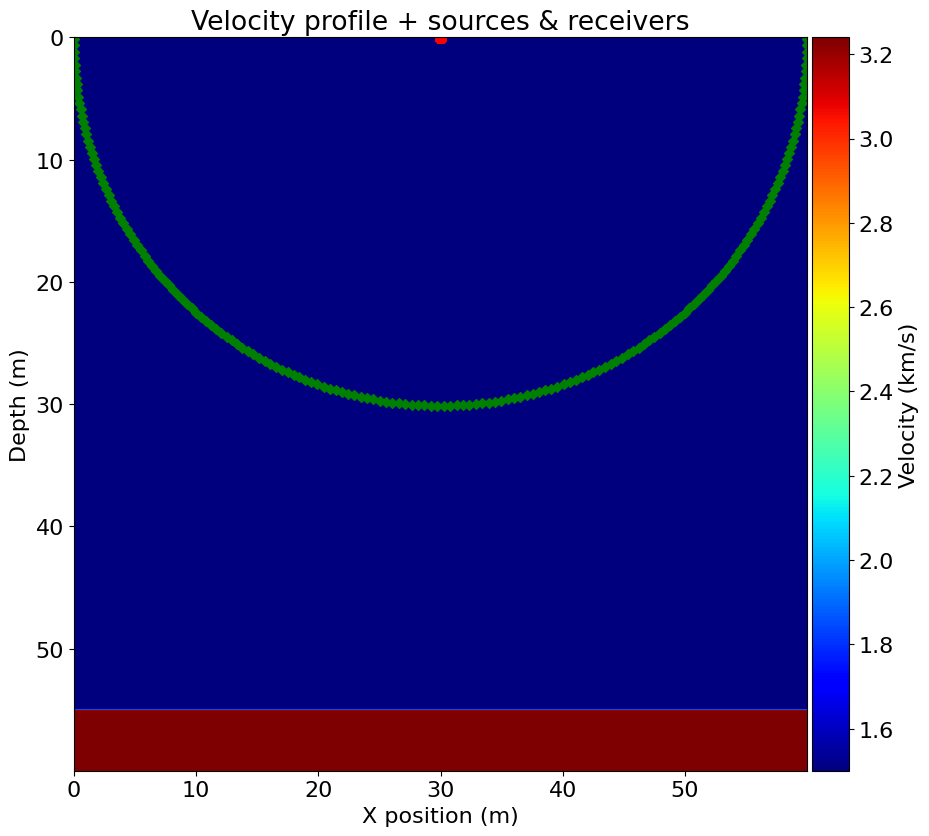

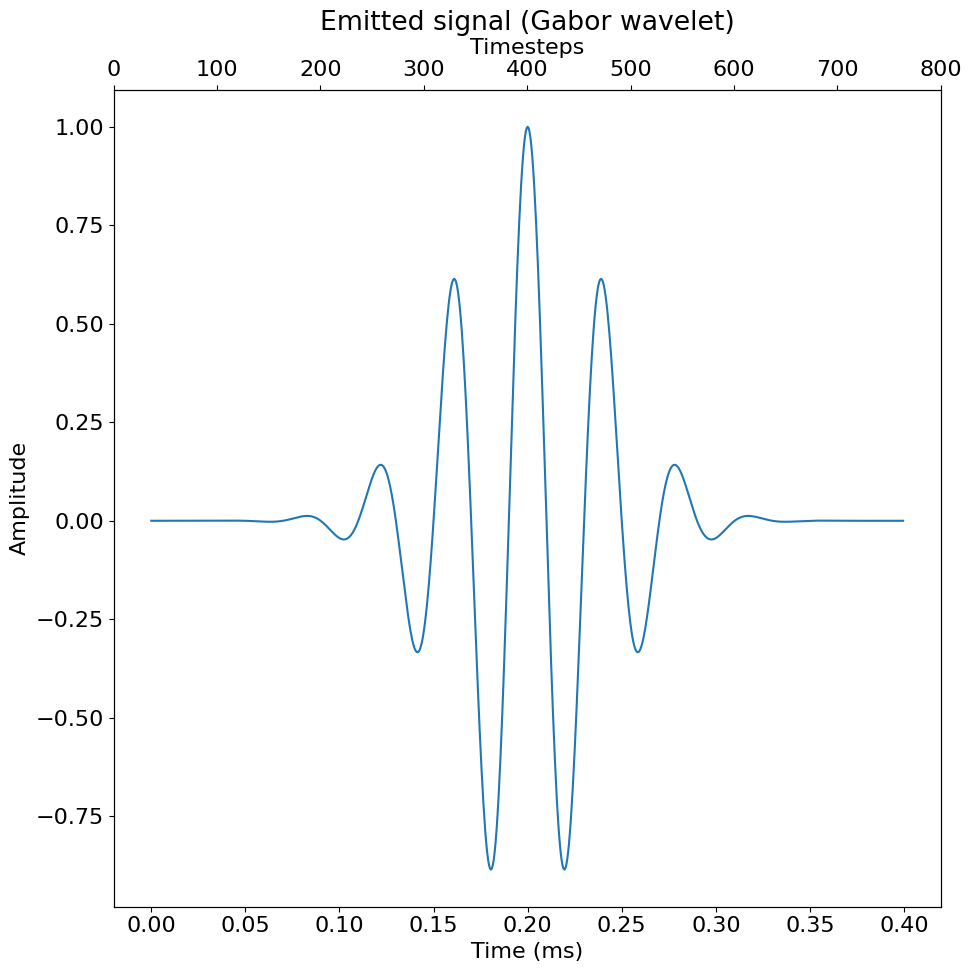

[stderr:1] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


In [6]:
%%px --no-stream --group-outputs=engine

plot_velocity(
    sonar.model,
    source=sonar.src.coordinates.data,
    receiver=sonar.rec.coordinates.data,
)
if rank == 0:
    plt.figure()
    plt.plot(sonar.src.time_values[:800], sonar.src.signal_packet)
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    ax2 = plt.gca().twiny()
    ax2.set_xlim(0, 800)
    ax2.set_xlabel("Timesteps")
    plt.title("Emitted signal (Gabor wavelet)")
    plt.tight_layout()
    plt.show()

In [7]:
%%px --group-outputs=engine

recordings = {}
for a in angles:
    sonar.run_beam(a)
    recordings[a] = comm.gather(sonar.rec.data, root=0)
    if rank == 0:
        recordings[a] = np.concatenate(recordings[a], axis=1)

[stderr:1] Allocating host memory for rec(188887, 90) [130 MB]
Allocating host memory for u(3, 3270, 6524) [488 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800157/ded4973e517008aca963617e186bbda64a8d77d7.cpp` in 0.06 s from jit-cache
Operator `Kernel` ran in 164.41 s
Global performance: [OI=1.16, 1800.44 GFlops/s, 48.66 GPts/s]
Local performance:
  * section0[rank0]<90> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section0[rank1]<90> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1[rank0]<188885,3254,6508> ran in 159.76 s [OI=1.16, 926.44 GFlops/s, 25.04 GPts/s]
  * section1[rank1]<188885,3254,6508> ran in 159.79 s [OI=1.16, 926.23 GFlops/s, 25.04 GPts/s]
  * section2[rank0]<<188885,64,2,2>,<188885,64,2,2>> ran in 2.17 s [OI=3.00, 1.35 GFlops/s, 0.03 GPts/s]
  * section2[rank1]<<188885,69,2,2>,<188885,69,2,2>> ran in 2.11 s [OI=3.00, 1.49 GFlops/s, 0.03 GPts/s]
  * section3[rank0]<<188885,90>,<188885,90,2,2>> ran in 2.22 s [OI=0.66, 0.33 GFlops/

[stderr:0] Allocating host memory for rec(188887, 90) [130 MB]
Allocating host memory for u(3, 3270, 6524) [488 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800157/ded4973e517008aca963617e186bbda64a8d77d7.cpp` in 0.06 s from jit-cache
Operator `Kernel` ran in 164.41 s
Global performance: [OI=1.16, 1800.44 GFlops/s, 48.66 GPts/s]
Local performance:
  * section0[rank0]<90> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section0[rank1]<90> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1[rank0]<188885,3254,6508> ran in 159.76 s [OI=1.16, 926.44 GFlops/s, 25.04 GPts/s]
  * section1[rank1]<188885,3254,6508> ran in 159.79 s [OI=1.16, 926.23 GFlops/s, 25.04 GPts/s]
  * section2[rank0]<<188885,64,2,2>,<188885,64,2,2>> ran in 2.17 s [OI=3.00, 1.35 GFlops/s, 0.03 GPts/s]
  * section2[rank1]<<188885,69,2,2>,<188885,69,2,2>> ran in 2.11 s [OI=3.00, 1.49 GFlops/s, 0.03 GPts/s]
  * section3[rank0]<<188885,90>,<188885,90,2,2>> ran in 2.22 s [OI=0.66, 0.33 GFlops/

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stdout:1] Simulation took 166.06660723686218 seconds
Simulation took 167.91519856452942 seconds
Simulation took 168.10273623466492 seconds
Simulation took 168.12554574012756 seconds
Simulation took 168.1475064754486 seconds
Simulation took 170.89204573631287 seconds
Simulation took 169.36182522773743 seconds


[stdout:0] Simulation took 166.0666115283966 seconds
Simulation took 167.8050889968872 seconds
Simulation took 167.9939832687378 seconds
Simulation took 168.01833367347717 seconds
Simulation took 168.03771948814392 seconds
Simulation took 170.78335762023926 seconds
Simulation took 169.25424337387085 seconds


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[output:0]

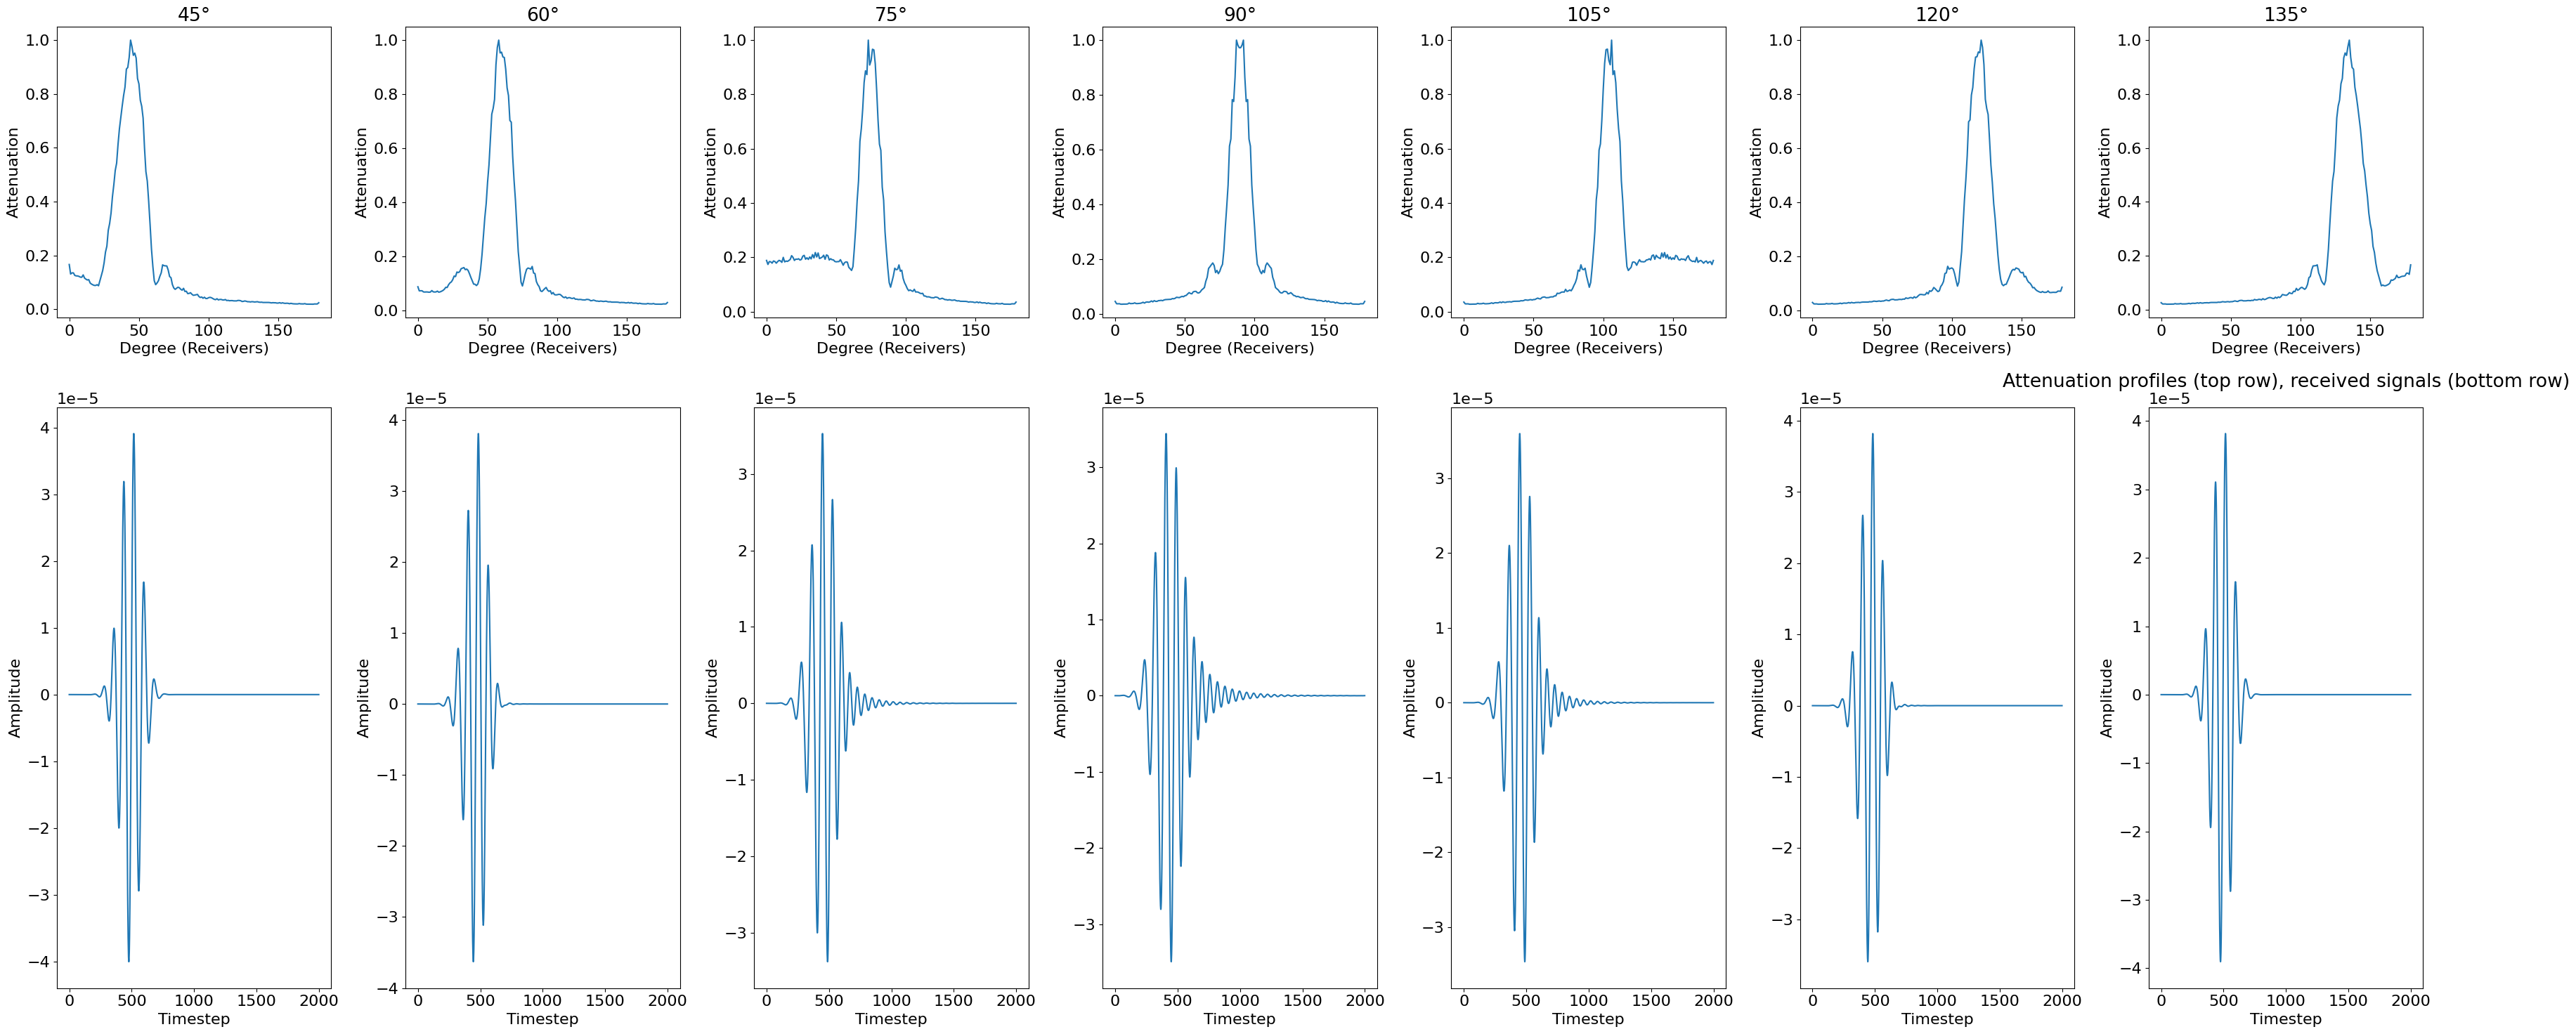

In [8]:
%%px --no-stream --group-outputs=engine

if rank == 0:
    fig, ax = plt.subplots(2, 7, figsize=(35, 15), gridspec_kw={"height_ratios": [1, 2]})
    plt.title("Attenuation profiles (top row), received signals (bottom row)")
    for i, (a, r) in enumerate(recordings.items()):
        recording = np.flip(r)
        ax[0, i].plot(
            np.max(np.abs(recording[:, :]), axis=0) / np.max(np.abs(recording[:, :]))
        )
        ax[0, i].set_xlabel("Degree (Receivers)")
        ax[0, i].set_ylabel("Attenuation")
        ax[0, i].set_title(f"{a}°")
        ax[0, i].tick_params()

        ax[1, i].plot(r[40000:42000, 180 - a])
        ax[1, i].set_xlabel("Timestep")
        ax[1, i].set_ylabel("Amplitude")
    fig.tight_layout()

### Detect multiple angles

In [3]:
%%px --no-stream --group-outputs=engine

domain_size = (60, 30)
v_env = 1.5
ns = 128
source_distance = 0.002
f0 = 50
space_order = 8
spatial_dist = round(v_env / f0 / 3, 6)
dt = spatial_dist / 20
angles = [30, 45, 60, 75, 90, 105, 120, 135, 150]

In [4]:
%%px --no-stream --group-outputs=engine

obstacle = True
v_wall = 5.64
v_obj = 3.24
domain_dims = (
    round(domain_size[0] / spatial_dist),
    round(domain_size[1] / spatial_dist),
)
vp = np.full(domain_dims, v_env, dtype=np.float32)
r_obs = vp.shape[0] / 20
a, b = vp.shape[0] / 4, vp.shape[1] - r_obs
y, x = np.ogrid[-a : vp.shape[0] - a, -b : vp.shape[1] - b]
vp[x * x + y * y <= r_obs * r_obs] = v_obj
nx = domain_dims[0]
nz = domain_dims[1]
wall = round(nx * 0.02)
offs = round(wall / 2)
a = round((nx - wall) / 2)
b = round((nz - wall) / 2)
offs = round(wall / 2)
x = np.arange(0, vp.shape[0])
y = np.arange(0, vp.shape[1])
if obstacle:
    r = vp.shape[0] / 100
    ox = np.arange(offs, 2 * a + offs + 1, 2 * a / 50)
    oy = np.sqrt(1 - (ox - a - offs) ** 2 / a**2) * b + offs + b
    for oxx, oyy in tqdm.tqdm(zip(ox, oy)):
        mask = (y[np.newaxis, :] - oyy) ** 2 + (
            x[:, np.newaxis] - oxx
        ) ** 2 < r**2
        vp[mask] = v_wall
mask = (y[np.newaxis, :] - offs - b) ** 2 / b**2 + (
    x[:, np.newaxis] - offs - a
) ** 2 / a**2 > 1
vp[mask] = v_wall
vp[offs:-offs, :b] = v_env

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
51it [00:05,  9.39it/s]
[stderr:1] 
51it [00:02, 21.77it/s]


In [5]:
%%px --no-stream --group-outputs=engine

sonar = Sonar(
    domain_size,
    f0,
    v_env,
    vp,
    space_order=space_order,
    dt=dt,
    spatial_dist=spatial_dist,
)

sonar.set_source()
sonar.set_receiver()
sonar.finalize()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Operator `initdamp` generated in 1.45 s
  * lowering.IET: 0.68 s (47.0 %)
     * specializing.IET: 0.46 s (31.8 %)
  * lowering.Clusters: 0.48 s (33.2 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800157/ff25a25afc1b0e3dc91c4b35109b4adaab240285.cpp` in 0.65 s from jit-cache
Operator `initdamp` ran in 1.53 s
Global performance: [OI=0.22, 0.04 GFlops/s]
Local performance:
  * section0[rank0]<> ran in 0.01 s 
  * section0[rank1]<> ran in 0.01 s 
  * section1[rank0]<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section2[rank0]<254,3508> ran in 0.01 s [OI=0.69, 306.30 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section4[rank1]<254,3508> ran in 0.01 s [OI=0.69, 306.30 GFlops/s, 0.00 GPts/s]
  * section5[rank0]<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section5[rank1]<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPt

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[output:0]

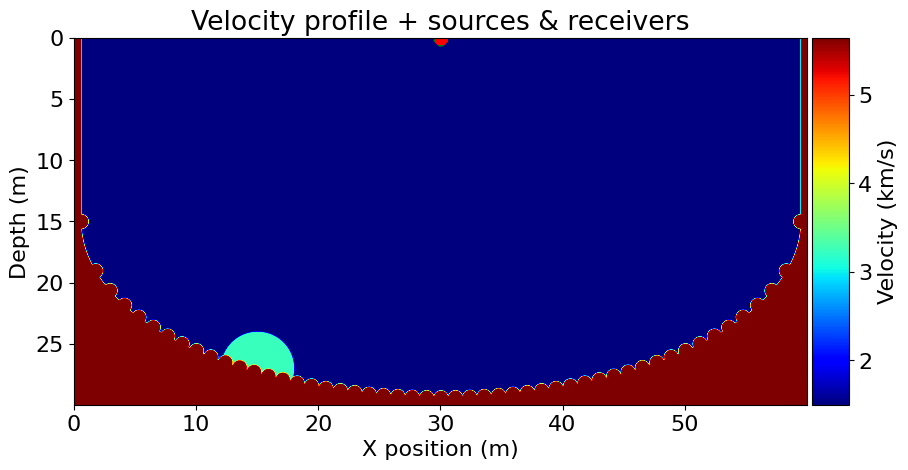

[stderr:1] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


In [6]:
%%px --no-stream --group-outputs=engine

plot_velocity(sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data)

In [7]:
%%px --no-stream --group-outputs=engine

recordings = {}
for a in angles:
    sonar.run_beam(a)
    recordings[a] = comm.gather(sonar.rec.data, root=0)
    if rank == 0:
        recordings[a] = np.concatenate(recordings[a], axis=1)

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stdout:0] 
Simulation took 174.29852557182312 seconds
Simulation took 174.25662088394165 seconds
Simulation took 173.77475237846375 seconds
Simulation took 167.103613615036 seconds
Simulation took 176.52294158935547 seconds
Simulation took 180.24167108535767 seconds
Simulation took 171.39765620231628 seconds
Simulation took 169.29514241218567 seconds
Simulation took 174.27672791481018 seconds
[stdout:1] 
Simulation took 175.66187191009521 seconds
Simulation took 175.83738493919373 seconds
Simulation took 174.79454064369202 seconds
Simulation took 167.87813711166382 seconds
Simulation took 177.7651126384735 seconds
Simulation took 181.6642668247223 seconds
Simulation took 172.46303415298462 seconds
Simulation took 170.48915648460388 seconds
Simulation took 175.35510540008545 seconds


[stderr:0] 
Allocating host memory for rec(123139, 64) [60 MB]
Allocating host memory for u(3, 3270, 3524) [264 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.cpp` in 0.19 s from jit-cache
Operator `Kernel` ran in 171.86 s
Global performance: [OI=1.28, 670.70 GFlops/s, 16.36 GPts/s]
Local performance:
  * section0[rank0]<64> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section0[rank1]<69> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1[rank0]<123137,3254,3508> ran in 164.66 s [OI=1.28, 350.00 GFlops/s, 8.54 GPts/s]
  * section1[rank1]<123137,3254,3508> ran in 168.48 s [OI=1.28, 342.07 GFlops/s, 8.35 GPts/s]
  * section2[rank0]<<123137,64,2,2>,<123137,64,2,2>> ran in 3.54 s [OI=3.00, 0.54 GFlops/s, 0.01 GPts/s]
  * section2[rank1]<<123137,69,2,2>,<123137,69,2,2>> ran in 1.63 s [OI=3.00, 1.26 GFlops/s, 0.03 GPts/s]
  * section3[rank0]<<123137,64>,<123137,64,2,2>> ran in 3.38 s [OI=0.66, 0.10 GFlops/s, 

In [8]:
%%px --no-stream --group-outputs=engine

rec_coords = comm.gather(sonar.rec.coordinates.data, root=0)
if rank == 0:
    rec_coords = np.concatenate(rec_coords, axis=0)

[stderr:0] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
[stderr:1] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


In [9]:
%%px

if rank == 0:
    ideal_signal = sonar.src.signal_packet
    coords = np.zeros((np.size(angles), 2))
    for a, v in recordings.items():
        coordinates = np.zeros((128, 2))
        for i in range(sonar.ns):
            start_time = np.argmax(v[:5000, i])
            correlate = np.correlate(v[5000:, i], ideal_signal, mode="same")
            peak = 5000 + correlate.argmax()
            distance = (
                peak - start_time
            ) * dt * v_env / 2
            rc = rec_coords[i]
            coordinates[i, 0] = rc[0] - distance * np.cos(np.deg2rad(a))
            coordinates[i, 1] = rc[1] + distance * np.sin(np.deg2rad(a))
            coords[a // 15 - 2, :] = np.mean(coordinates, axis=0)
else:
    coords = None
coords = comm.bcast(coords, root=0)

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[output:0]

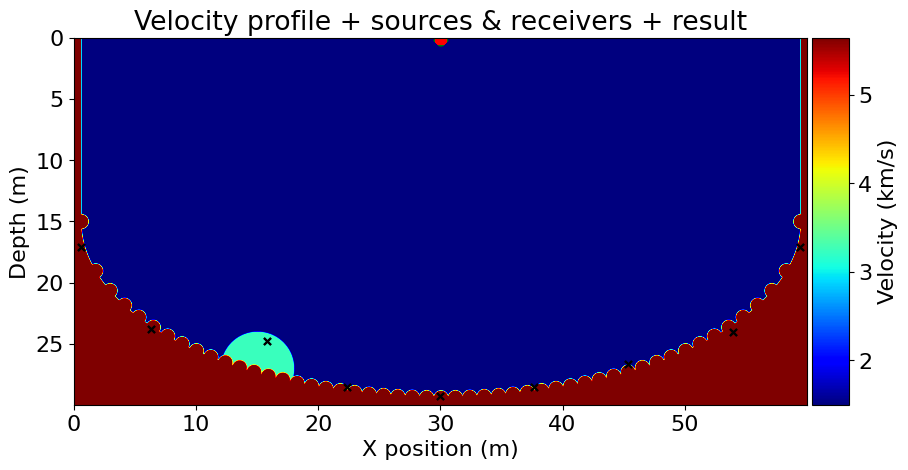

[stderr:1] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


In [10]:
%%px --no-stream --group-outputs=engine

plot_velocity(sonar.model, sonar.src.coordinates.data, sonar.rec.coordinates.data, coords)